In [2]:
import sys, os
os.path.dirname(sys.executable)
sys.path.append('/global/scratch/users/sergiomar10/ESCMBA/ESMCBA/ESMCBA')

In [3]:
from ESMCBA.imports import *
from ESMCBA import graph_utils

In [7]:
evaluations_dt = pd.read_csv('performances/models_performances_05032025.csv')
evaluations_dt = evaluations_dt.iloc[:, 1:]
evaluations_dt = evaluations_dt.sort_values(by='spearman', ascending = False).reset_index(drop=True)
evaluations_dt.head(5)

,HLA,Losses,encoding,data_prop,trained_blocks,lr_transformer,lr_regression,n_evaluations,spearman,pearsonr,mse,mae,r2,rmse,time,path
0,HLAB1801,Hubber,HLA,0.80,30,0.0001,0.000010,12,0.867133,0.914945,1.108200,0.848268,0.609242,1.052711,2025-03-04 04:38:55,/global/scratch/users/sergiomar10/losses/ESMCB...
1,HLAA2601,MSE,HLA,0.50,30,0.0001,0.000010,15,0.864286,0.862720,0.732143,0.595892,0.607185,0.855653,2025-03-04 13:10:46,/global/scratch/users/sergiomar10/losses/ESMCB...
2,HLAB1801,MSE,HLA,0.80,30,0.0001,0.000001,12,0.860140,0.900747,1.368902,1.000458,0.517317,1.170001,2025-03-05 06:07:02,/global/scratch/users/sergiomar10/losses/ESMCB...
3,HLAB0801,Hubber,epitope,0.95,20,0.0001,0.001000,16,0.857361,0.851606,1.805032,1.229421,0.095840,1.343515,2025-03-04 04:15:00,/global/scratch/users/sergiomar10/losses/ESMCB...
4,HLAB0801,MSE,epitope,0.80,30,0.0001,0.001000,16,0.854353,0.840859,1.530798,1.117961,0.233207,1.237254,2025-03-04 12:00:30,/global/scratch/users/sergiomar10/losses/ESMCB...


In [9]:
evaluations_dt_sorted = evaluations_dt.drop_duplicates('HLA')
# evaluations_dt_sorted

In [10]:
combined_metrics = []

for HLA, path in evaluations_dt_sorted[['HLA', 'path']].values:
    # for i in range(10):
    try:
        HLA = HLA.replace('HLA', 'HLA-')
        if len(glob.glob(f'/global/scratch/users/sergiomar10/data/MHCFlurry_evals/*{HLA}_mhc_flurry.csv')) < 1:
            continue
            
        replicate_spearman = []
        replicate_pearson = []
        
        # Get all replicate CSV files using a glob pattern derived from 'path'
        file_paths = glob.glob(f'{path[:155]}*')
        print(f"{len(file_paths)} replicates for {HLA}")
        
        # Load the MHC Flurry predictions (assumed constant for each HLA)
        mhc_pred = pd.read_csv(f'/global/scratch/users/sergiomar10/data/MHCFlurry_evals/{HLA}_mhc_flurry.csv')
        label = HLA
        # Loop over each replicate CSV file for the fine-tuned ESMC predictions
        for rep_path in file_paths:
            last_csv = pd.read_csv(rep_path)
            
            # Adjust the sequence if needed
            if len(last_csv['sequence'].iloc[0]) > 300:
                last_csv['sequence'] = last_csv['sequence'].apply(lambda x: x[365:])
                predictions_rep = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
                # Fallback if the slicing didn't match any peptides.
                if predictions_rep['peptide'].notna().sum() == 0:
                    last_csv = pd.read_csv(rep_path)
                    last_csv['sequence'] = last_csv['sequence'].apply(lambda x: x[362:])
                    predictions_rep = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
            else:
                predictions_rep = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
            
            # Compute log-transformed MHC affinity and filter out rows with missing values
            predictions_rep['mhc_log'] = predictions_rep['mhcflurry_affinity'].apply(np.log10)
            predictions_rep = predictions_rep[predictions_rep['mhc_log'].notna()]
    
            
            # Compute correlation metrics for this replicate
            sp, _ = spearmanr(predictions_rep['measured'], predictions_rep['prediction'])
            pr, _ = pearsonr(predictions_rep['measured'], predictions_rep['prediction'])
            replicate_spearman.append(sp)
            replicate_pearson.append(pr)
        
        # Compute mean and standard deviation across replicates for fine-tuned ESMC
        # If there are no replicates, default to NaN
        esmc_sp_mean = np.mean(replicate_spearman) if replicate_spearman else np.nan
        esmc_sp_std = np.std(replicate_spearman) if replicate_spearman else np.nan
        esmc_pr_mean = np.mean(replicate_pearson) if replicate_pearson else np.nan
        esmc_pr_std = np.std(replicate_pearson) if replicate_pearson else np.nan
    
        # print(HLA, label, esmc_sp_mean, esmc_sp_std)
        
        # Append the fine-tuned ESMC metrics with error bars
        combined_metrics.append({
            'HLA': HLA,
            'model': 'Fine-tuned ESMC',
            'label': label,
            'spearman': esmc_sp_mean,
            'spearman_std': esmc_sp_std,
            'pearson': esmc_pr_mean,
            'pearson_std': esmc_pr_std
        })
          
        sp_mhc, _ = spearmanr(predictions_rep['measured'], predictions_rep['mhc_log'])
        pr_mhc, _ = pearsonr(predictions_rep['measured'], predictions_rep['mhc_log'])
        
        combined_metrics.append({
            'HLA': HLA,
            'model': 'MHC Flurry',
            'label': label,
            'spearman': sp_mhc,
            'spearman_std': 0,  # Single CSV file: no replicate standard deviation.
            'pearson': pr_mhc,
            'pearson_std': 0
        })
    except:
        print(HLA)

combined_df = pd.DataFrame(combined_metrics)

1 replicates for HLA-B1801
HLA-B1801
1 replicates for HLA-A2601
3 replicates for HLA-B0801
1 replicates for HLA-A3001
1 replicates for HLA-A0203
3 replicates for HLA-B1501
4 replicates for HLA-A0206
2 replicates for HLA-A6801
2 replicates for HLA-B3501
1 replicates for HLA-A2301
1 replicates for HLA-A0202
2 replicates for HLA-A1101
1 replicates for HLA-B3901
1 replicates for HLA-A2403
1 replicates for HLA-B5801
1 replicates for HLA-B1517
1 replicates for HLA-A6802
1 replicates for HLA-A3002
1 replicates for HLA-A2902
4 replicates for HLA-B0702
4 replicates for HLA-A3301
1 replicates for HLA-A0301
2 replicates for HLA-A0101
1 replicates for HLA-A0201
1 replicates for HLA-A2402
1 replicates for HLA-B5101
1 replicates for HLA-B4402
3 replicates for HLA-A6901
2 replicates for HLA-B5701
2 replicates for HLA-B4601


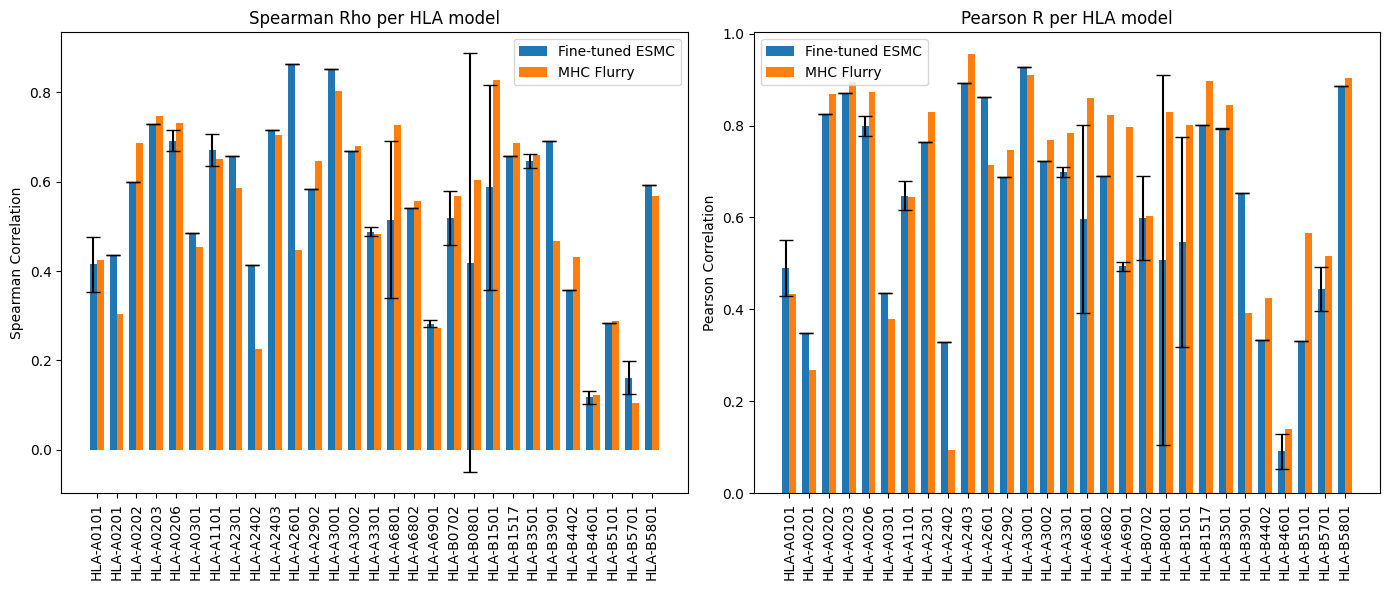

In [11]:
# Pivot the combined DataFrame to get values (and error bars) per HLA and model.
pivot_spearman     = combined_df.pivot(index='HLA', columns='model', values='spearman')
pivot_spearman_std = combined_df.pivot(index='HLA', columns='model', values='spearman_std')
pivot_pearson      = combined_df.pivot(index='HLA', columns='model', values='pearson')
pivot_pearson_std  = combined_df.pivot(index='HLA', columns='model', values='pearson_std')

# X-axis positions for each HLA.
x = np.arange(len(pivot_spearman.index))
width = 0.35  # width for each bar

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Spearman correlations:
# - Fine-tuned ESMC: with error bars from the aggregated data.
# - MHC Flurry: without error bars.
axes[0].bar(x - width/2, pivot_spearman['Fine-tuned ESMC'], width, 
            yerr=pivot_spearman_std['Fine-tuned ESMC'], capsize=5, label='Fine-tuned ESMC')
axes[0].bar(x + width/2, pivot_spearman['MHC Flurry'], width, label='MHC Flurry')
axes[0].set_xticks(x)
axes[0].set_xticklabels(pivot_spearman.index, rotation=90)
axes[0].set_ylabel('Spearman Correlation')
axes[0].set_title('Spearman Rho per HLA model')
axes[0].legend()

# Plot Pearson correlations:
# - Fine-tuned ESMC: with error bars from the aggregated data.
# - MHC Flurry: without error bars.
axes[1].bar(x - width/2, pivot_pearson['Fine-tuned ESMC'], width,
            yerr=pivot_pearson_std['Fine-tuned ESMC'], capsize=5, label='Fine-tuned ESMC')
axes[1].bar(x + width/2, pivot_pearson['MHC Flurry'], width, label='MHC Flurry')
axes[1].set_xticks(x)
axes[1].set_xticklabels(pivot_pearson.index, rotation=90)
axes[1].set_ylabel('Pearson Correlation')
axes[1].set_title('Pearson R per HLA model')
axes[1].legend()

plt.tight_layout()
plt.show()


In [13]:
# import math 
# hlas = evaluations_dt_sorted['HLA'].unique()
# n_hlas = len(hlas)
# cols = 5  # adjust as needed for layout
# rows = math.ceil(n_hlas / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), sharex=True, sharey=True)
# axes = axes.flatten()

# for i, (HLA, path) in enumerate(evaluations_dt_sorted[['HLA', 'path']].values):
#     ax = axes[i]
#     try:
#         # Load the fine-tuned model predictions.
#         last_csv = pd.read_csv(path)
#         # Load the MHC Flurry predictions.
#         mhc_pred = pd.read_csv(f'/global/scratch/users/sergiomar10/data/MHCFlurry_evals/{HLA}_mhc_flurry.csv')
        
#         # Here, we use HLA as a simple label; adjust if you want to extract a more detailed label.
#         label = HLA
        
#         # Merge predictions on sequence/peptide.
#         predictions = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
        
#         # Compute the log-transformed MHC Flurry affinity.
#         predictions['mhc_log'] = predictions['mhcflurry_affinity'].apply(np.log10)
#         predictions = predictions[predictions['mhc_log'].notna()]
        
#         # If no predictions remain, skip this HLA.
#         if predictions.empty:
#             continue
        
#         # X: MHC Flurry log predictions; Y: fine-tuned predictions (assumed to be in the 'prediction' column)
#         x_vals = predictions['mhc_log']
#         y_vals = predictions['prediction']
        
#         # Create the scatter plot.
#         ax.scatter(x_vals, y_vals, alpha=0.7, s=20, color='royalblue')
        
#         # Determine limits for a balanced plot.
#         all_vals = np.concatenate([x_vals.values, y_vals.values])
#         min_val, max_val = np.min(all_vals), np.max(all_vals)
#         pad = (max_val - min_val) * 0.05
#         lims = [min_val - pad, max_val + pad]
        
#         # Plot the x=y reference line.
#         ax.plot(lims, lims, 'k--', alpha=0.6, lw=1)
#         ax.set_xlim(lims)
#         ax.set_ylim(lims)
        
#         # Compute and annotate the percentage of points where fine-tuned prediction > MHC Flurry.
#         n_points = len(predictions)
#         if n_points > 0:
#             pct_above = np.sum(y_vals > x_vals) / n_points * 100
#             # The annotation is placed in the top left corner of the subplot.
#             ax.text(0.05, 0.95, f'> {pct_above:.1f}%', transform=ax.transAxes,
#                     verticalalignment='top', fontsize=9,
#                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
#         ax.set_title(f'{HLA}', fontsize=10)
        
#         # Optionally, label the leftmost subplots with Y label and bottom subplots with X label.
#         if i % cols == 0:
#             ax.set_ylabel('Fine-tuned Prediction', fontsize=9)
#         if i // cols == rows - 1:
#             ax.set_xlabel('MHC Flurry (log-transformed)', fontsize=9)
        
#     except Exception as e:
#         print(f"Error processing {HLA}: {e}")
#         continue

# # Remove any unused subplots.
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.suptitle('Comparison of Fine-tuned ESMC vs. MHC Flurry Predictions across 30 HLAs', fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

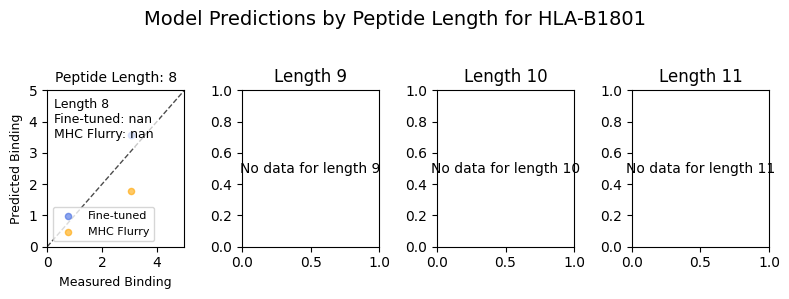

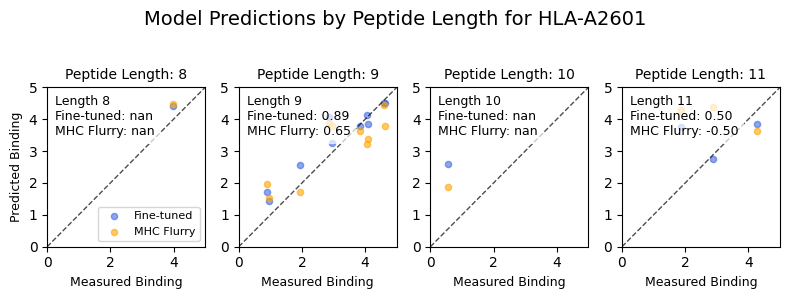

/tmp/ipykernel_2066968/710326031.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_2066968/710326031.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


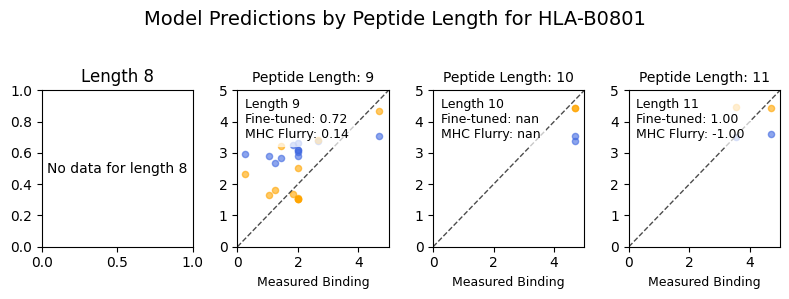

/tmp/ipykernel_2066968/710326031.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_2066968/710326031.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


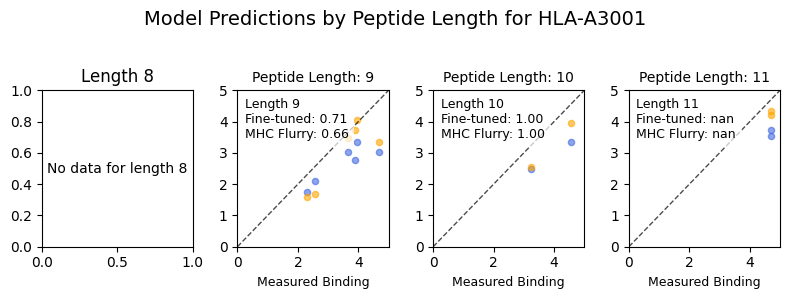

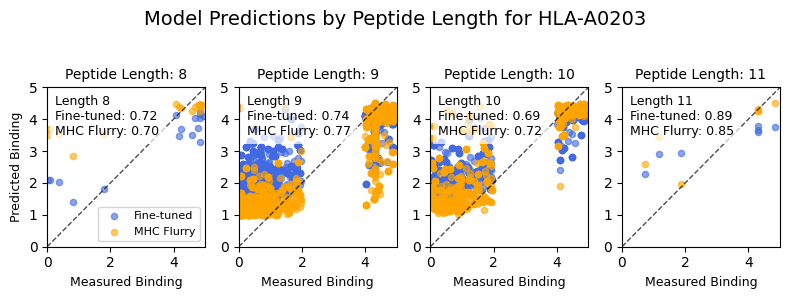

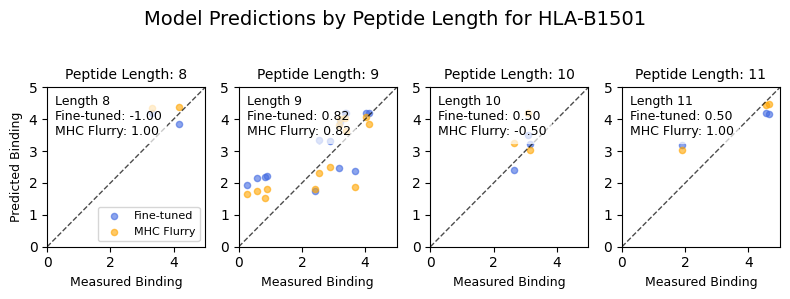

/tmp/ipykernel_2066968/710326031.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_2066968/710326031.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


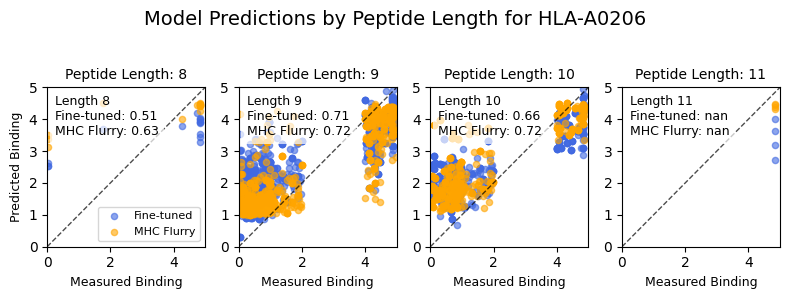

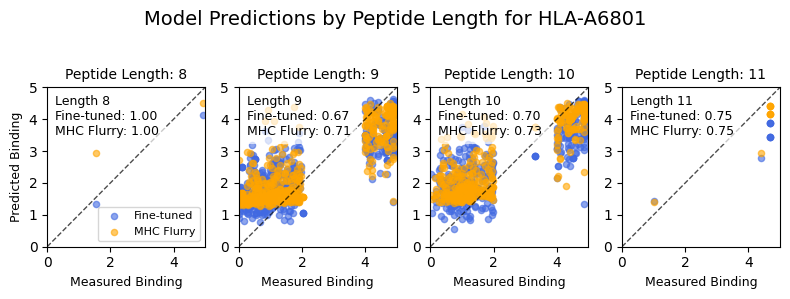

/tmp/ipykernel_2066968/710326031.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_2066968/710326031.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


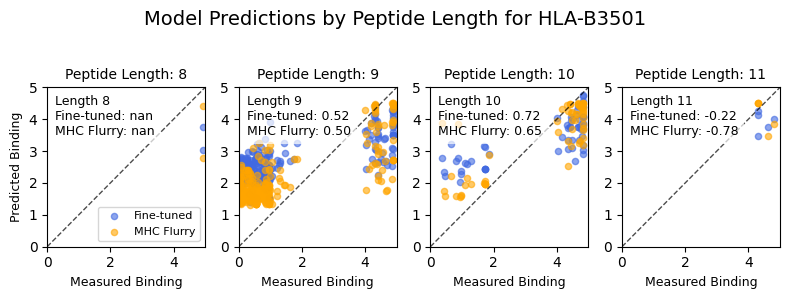

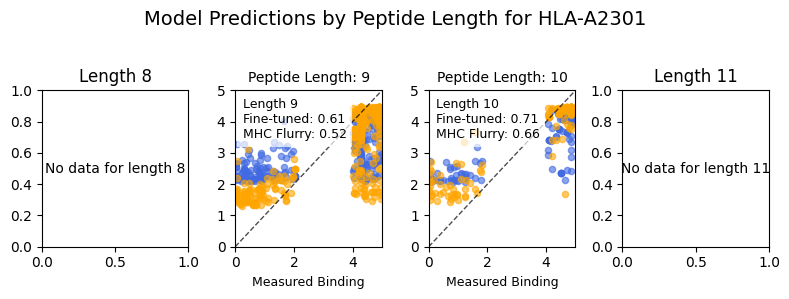

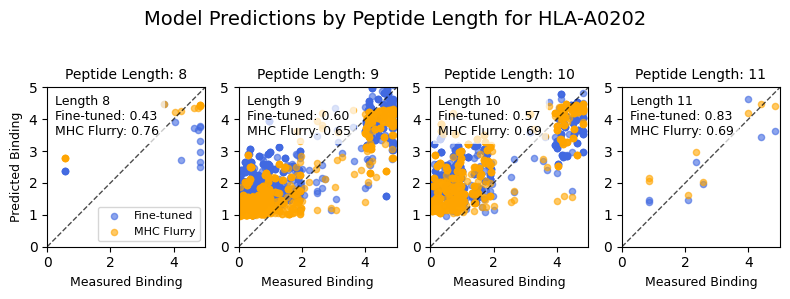

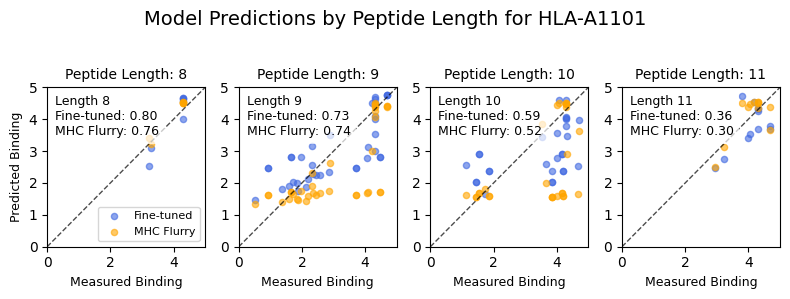

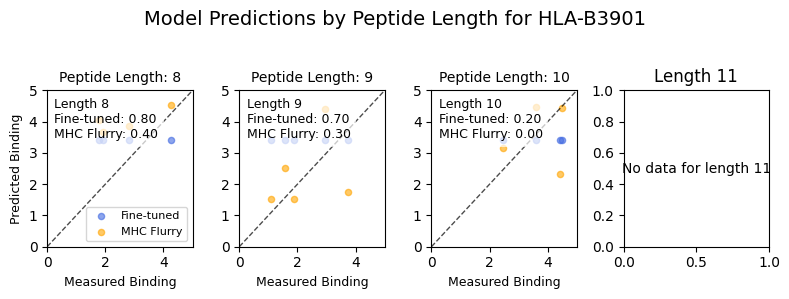

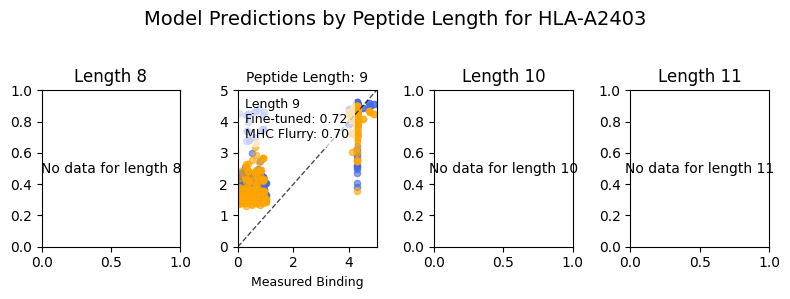

/tmp/ipykernel_2066968/710326031.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_2066968/710326031.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


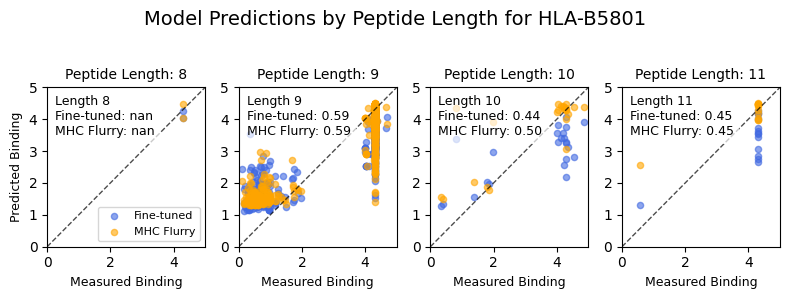

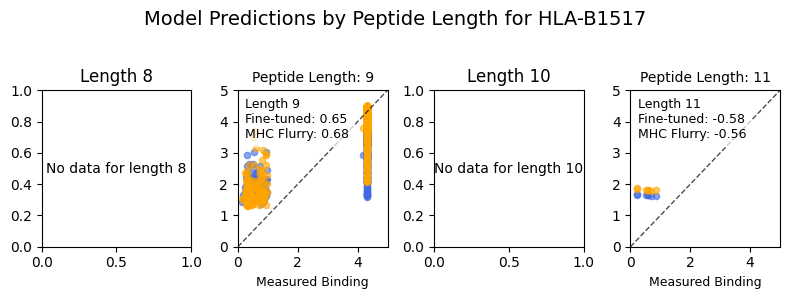

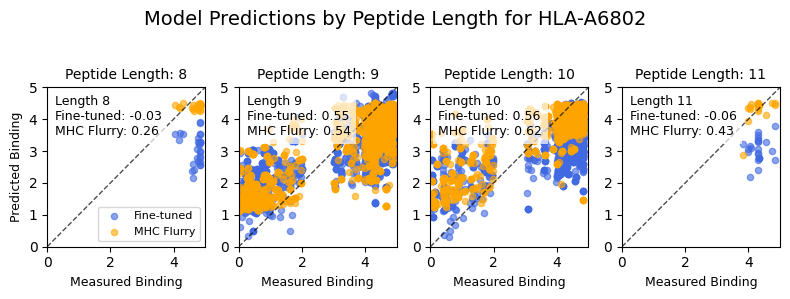

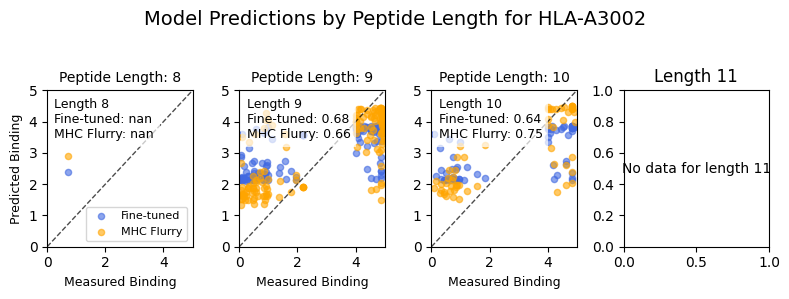

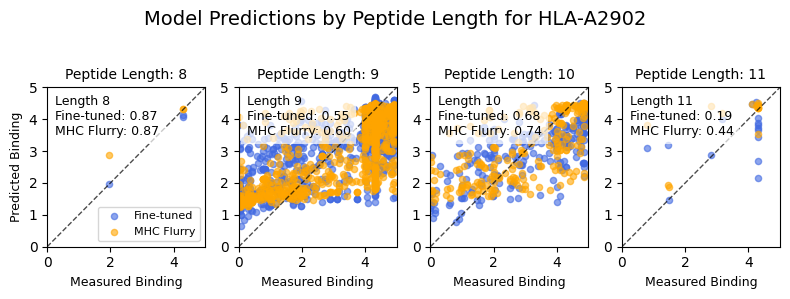

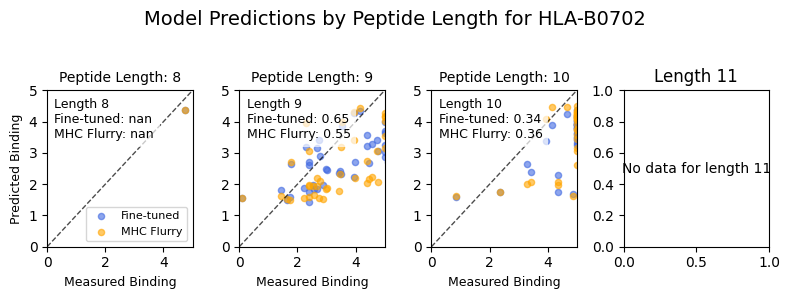

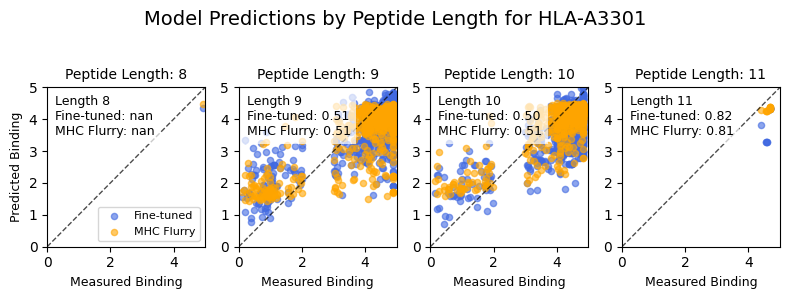

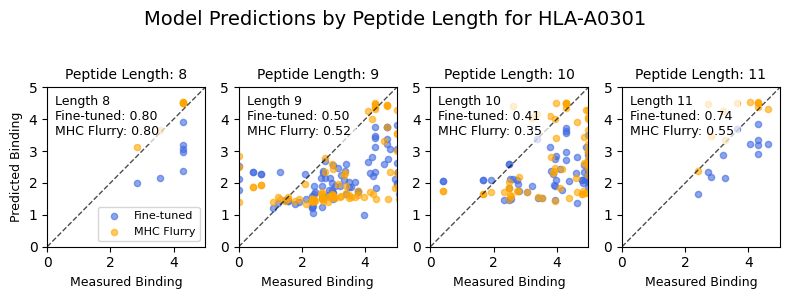

/tmp/ipykernel_2066968/710326031.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
/tmp/ipykernel_2066968/710326031.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])


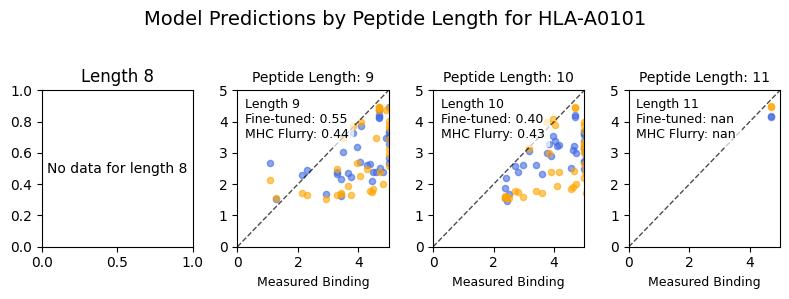

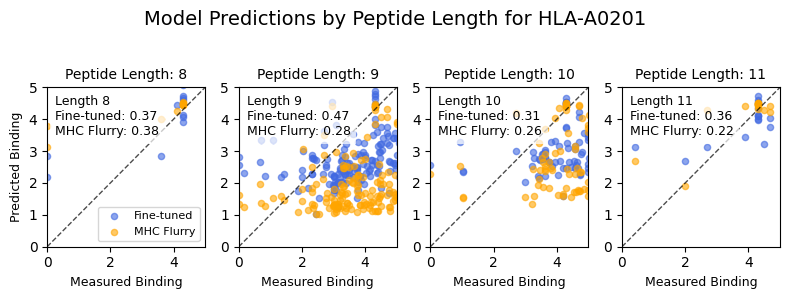

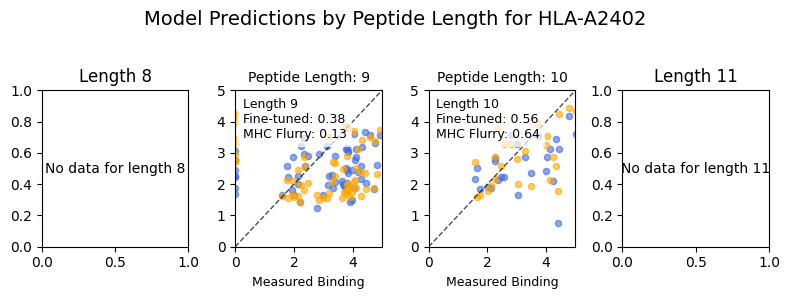

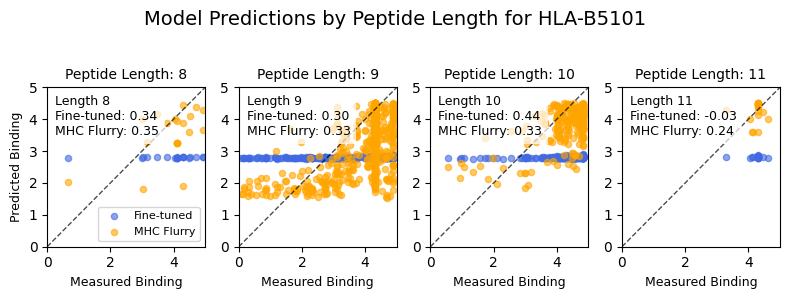

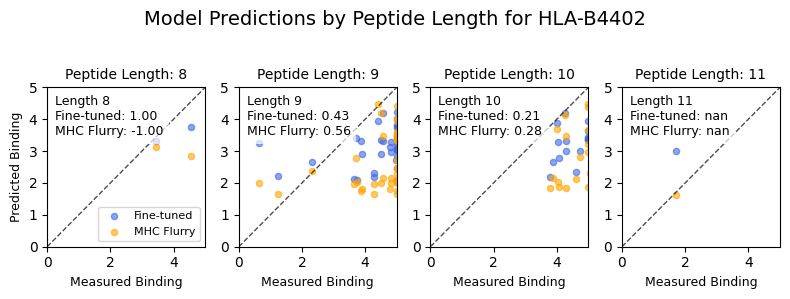

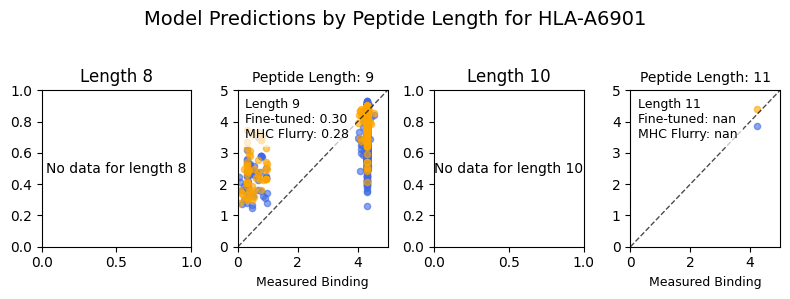

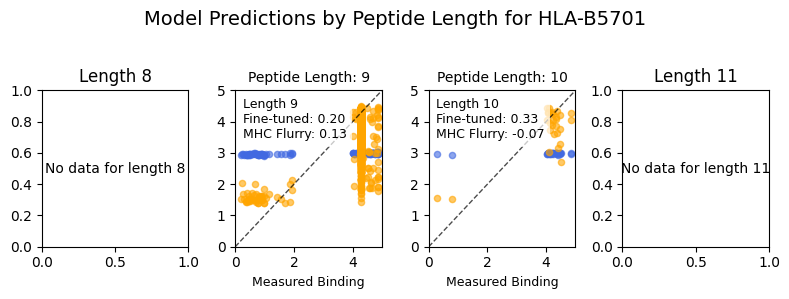

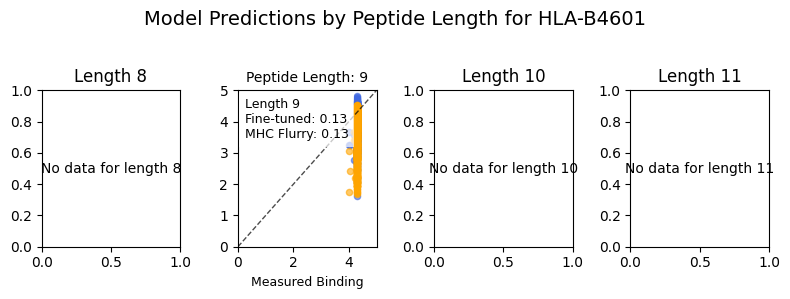

In [14]:
for HLA, path in evaluations_dt_sorted[['HLA', 'path']].values:
    try:
        HLA = HLA.replace('HLA', 'HLA-')
        last_csv = pd.read_csv(path)
        # Load MHC Flurry predictions.
        mhc_pred = pd.read_csv(f'/global/scratch/users/sergiomar10/data/MHCFlurry_evals/{HLA}_mhc_flurry.csv')
        
        # Check and trim sequences if they are longer than 300 characters.
        if len(last_csv['sequence'].iloc[0]) > 300:
            last_csv['sequence'] = last_csv['sequence'].apply(lambda x: x[365:])
            predictions = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
            # Fallback: if no peptides matched, try a slightly different trimming.
            if predictions['peptide'].notna().sum() == 0:
                last_csv = pd.read_csv(path)
                last_csv['sequence'] = last_csv['sequence'].apply(lambda x: x[362:])
                predictions = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
        else:
            predictions = pd.merge(last_csv, mhc_pred, left_on='sequence', right_on='peptide', how='left')
        
        # Compute the log-transformed affinity for MHC Flurry.
        predictions['mhc_log'] = predictions['mhcflurry_affinity'].apply(np.log10)
        predictions = predictions[predictions['mhc_log'].notna()]
        
        # Create a new column for peptide length.
        predictions['length'] = predictions['sequence'].str.len()
        
        # Prepare a figure with 1 row and 4 columns for peptide lengths 8, 9, 10, and 11.
        fig, axes = plt.subplots(1, 4, figsize=(8, 3), sharex=False, sharey=False)
        
        # Loop over the four peptide lengths.
        for idx, L in enumerate([8, 9, 10, 11]):
            ax = axes[idx]
            preds_length = predictions[predictions['length'] == L]
            if preds_length.empty:
                ax.text(0.5, 0.5, f"No data for length {L}", ha='center', va='center')
                ax.set_title(f"Length {L}")
                continue
                
            # Scatter plots:
            # Fine-tuned predictions (assumed in column 'prediction')
            ax.scatter(preds_length['measured'], preds_length['prediction'], 
                       color='royalblue', alpha=0.6, s=20, label='Fine-tuned')
            # MHC Flurry predictions (log-transformed)
            ax.scatter(preds_length['measured'], preds_length['mhc_log'], 
                       color='orange', alpha=0.6, s=20, label='MHC Flurry')
            
            # Determine common limits for the x=y line.
            all_vals = np.concatenate([
                preds_length['measured'].values, 
                preds_length['prediction'].values,
                preds_length['mhc_log'].values
            ])
            min_val, max_val = np.min(all_vals), np.max(all_vals)
            pad = (max_val - min_val) * 0.05
            lims = [min_val - pad, max_val + pad]
            ax.plot([0,5], [0,5], 'k--', alpha=0.7, lw=1)
            ax.set_xlim([0,5])
            ax.set_ylim([0,5])
            
            # Compute Spearman correlations for each model.
            sp_finetuned, _ = spearmanr(preds_length['measured'], preds_length['prediction'])
            sp_mhc, _       = spearmanr(preds_length['measured'], preds_length['mhc_log'])
            
            # Annotate the panel with Spearman correlation values.
            annotation = (f"Length {L}\n"
                          f"Fine-tuned: {sp_finetuned:.2f}\n"
                          f"MHC Flurry: {sp_mhc:.2f}")
            ax.text(0.05, 0.95, annotation, transform=ax.transAxes,
                    verticalalignment='top', fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            ax.set_title(f"Peptide Length: {L}", fontsize=10)
            if idx == 0:
                ax.set_ylabel("Predicted Binding", fontsize=9)
            ax.set_xlabel("Measured Binding", fontsize=9)
            if idx == 0:
                ax.legend(fontsize=8)
        
        fig.suptitle(f"Model Predictions by Peptide Length for {HLA}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Save the figure with the HLA name in the specified folder.
        save_path = f'/global/scratch/users/sergiomar10/data/figures_presentation/{HLA}.png'
        # plt.savefig(save_path, dpi=300)
        # plt.close(fig)
        plt.show()
        
    except Exception as e:
        print(f"Error processing {HLA}: {e}")